# Part 4: Web Mining the Log Data for a Website

## 4.1 Data Preprocessing
### 4.1.1. Load data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Stephen/Case Study 2/datasets/web_log_data.csv', na_filter=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 6 columns):
ip           5866 non-null object
date_time    5866 non-null object
request      5866 non-null object
step         5866 non-null int64
session      5866 non-null int64
user_id      5866 non-null int64
dtypes: int64(3), object(3)
memory usage: 275.0+ KB


From briefly viewing the data, we can see it contains following information

`IP`: the address user access from

`date_time`: the time that user made requests 

`request`: request URLs

`step`: the order of users made different requests

`session`: 

`user_id`:



In [25]:
#df = df.drop(['ip'], axis=1)
#df = df.drop(['session'], axis=1)
#df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 5 columns):
date_time    5866 non-null object
request      5866 non-null object
step         5866 non-null int64
session      5866 non-null int64
user_id      5866 non-null int64
dtypes: int64(3), object(2)
memory usage: 229.2+ KB


## 4.1.2. Inspect data type

We convert `date_time` into DataFrame format 

In [33]:
df['date_time'] = pd.to_datetime(df['date_time'], format="%d/%b/%Y:%H:%M:%S")  

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 6 columns):
ip           5866 non-null object
date_time    5866 non-null datetime64[ns]
request      5866 non-null object
step         5866 non-null int64
session      5866 non-null int64
user_id      5866 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 275.0+ KB


## 4.1.3. Sort values

In [4]:
df.head(5)

,ip,date_time,request,step,session,user_id,Day,Month,Hour,Day_of_week
0,c210-49-32-6.rochd2.,2005-04-18 21:25:07,/,1,3,3,18,4,21,0
1,visp.inabox.telstra.,2005-04-19 08:24:28,/,1,12,12,19,4,8,1
2,dsl-61-95-54-84.requ,2005-04-19 08:33:01,/,1,13,13,19,4,8,1
3,d220-236-91-52.dsl.n,2005-04-19 09:16:06,/,1,15,15,19,4,9,1
4,allptrs.eq.edu.au,2005-04-19 09:47:54,/,1,22,22,19,4,9,1


In [28]:
df = df.sort_values(by = ['user_id', 'step'], ascending=True)

df.head(5)

,ip,date_time,request,step,session,user_id,Day,Month,Hour,Day_of_week
5014,j2439.inktomisearch.,2005-04-18 21:16:54,/robots.txt,1,1,1,18,4,21,0
967,lj2559.inktomisearch,2005-04-18 21:16:55,/code/Global/code/menu.html,1,2,2,18,4,21,0
0,c210-49-32-6.rochd2.,2005-04-18 21:25:07,/,1,3,3,18,4,21,0
3408,c210-49-32-6.rochd2.,2005-04-18 21:25:08,/favicon.ico,2,3,3,18,4,21,0
5409,c210-49-32-6.rochd2.,2005-04-18 21:25:16,/services.html,3,3,3,18,4,21,0


We notice that many `request` value are only '/'. So we check `request` for more details:

In [34]:
print(df['request'].value_counts())

/                                                                821
/favicon.ico                                                     554
/robots.txt                                                      395
/eaglefarm/javascript/menu.js                                    370
/eaglefarm/pdf/Web_Price_List.pdf                                296
/eaglefarm/                                                      286
/services.html                                                   244
/eaglefarm/pricelist/                                            189
/eaglefarm/pricelist                                             187
/more.html                                                       145
/direct.html                                                     107
/eaglefarm/specials/                                             103
/eaglefarm/contact                                                95
/eaglefarm/contact/                                               93
/eaglefarm                        

From `value_count` of `request`, we can see that '/' refers to homepage of the website ,and many requests are same except ending with backslash.

So we replace '/' as `homepage`, and remove '/' at the end of equests.

In [35]:
df['request'] = df['request'].str.rstrip('\/')
df.replace(r'^\s*$', 'homepage', regex=True, inplace = True)

print(df['request'].value_counts())

homepage                                                         821
/favicon.ico                                                     554
/robots.txt                                                      395
/eaglefarm                                                       378
/eaglefarm/pricelist                                             376
/eaglefarm/javascript/menu.js                                    370
/eaglefarm/pdf/Web_Price_List.pdf                                296
/services.html                                                   244
/eaglefarm/contact                                               188
/eaglefarm/specials                                              174
/richlands                                                       169
/more.html                                                       145
/richlands/contact                                               126
/direct.html                                                     107
/eaglefarm/fileupload             

In [99]:
df['day'] = df['date_time'].dt.day
df['month'] = df['date_time'].dt.month
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5866 entries, 0 to 5865
Data columns (total 14 columns):
ip             5866 non-null object
date_time      5866 non-null datetime64[ns]
request        5866 non-null object
step           5866 non-null int64
session        5866 non-null int64
user_id        5866 non-null int64
Day            5866 non-null int64
Month          5866 non-null int64
Hour           5866 non-null int64
Day_of_week    5866 non-null int64
day            5866 non-null int64
month          5866 non-null int64
hour           5866 non-null int64
day_of_week    5866 non-null int64
dtypes: datetime64[ns](1), int64(11), object(2)
memory usage: 641.7+ KB


# 4.2. Data features
## 4.2.1. Number of Daily Request 

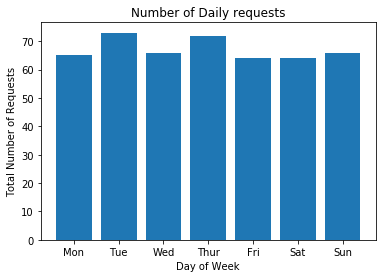

In [100]:
# Counting number of session per day of week
requestDayofWeek = df.groupby('day_of_week')['request'].nunique()
requestDayofWeek = pd.DataFrame(requestDayofWeek)
requestDayofWeek.columns= ['NumOfRequests']

# plotting bar chart number session each day of weeek
day=('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun')
x_axis=requestDayofWeek.index
plt.bar(x_axis,requestDayofWeek['NumOfRequests'])
plt.xticks(x_axis, day)
plt.ylabel('Total Number of Requests')
plt.xlabel('Day of Week')
plt.title('Number of Daily requests')
plt.show()

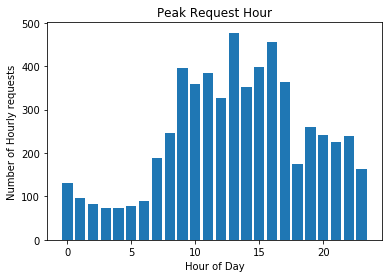

In [119]:
# Counting number of requests per hour of the day
requestPerHour = df.groupby('hour')['request'].size()
requestPerHour = pd.DataFrame(data=requestPerHour)
requestPerHour.columns= ['NumOfHourlyRequest']

# plotting bar chart of hourly session data
x_axis=requestPerHour.index
plt.bar(x_axis,requestPerHour['NumOfHourlyRequest'])
plt.ylabel('Number of Hourly requests')
plt.xlabel('Hour of Day')
plt.title('Peak Request Hour')
plt.show()

## 4.2.2. Number of Visits

In [116]:
df_DayOfWeek = df.groupby(['day_of_week','hour'])['request'].nunique()

df_DayOfWeek.sort_index(inplace=True)
df_DayOfWeek = pd.DataFrame(data=df_DayOfWeek)
df_DayOfWeek.columns = ['NumOfRequest']
df_DayOfWeek = pd.DataFrame(df_DayOfWeek.to_records())

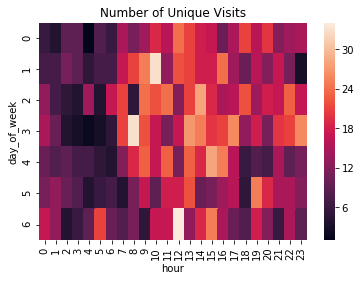

In [117]:
df_DayOfWeek = df_DayOfWeek.pivot("day_of_week", "hour", "NumOfRequest")

import seaborn as sns

ax = sns.heatmap(df_DayOfWeek)
#plt.yticks(x_axis, DayofWeek)
plt.title('Number of Unique Visits')
plt.show(ax)

In [24]:
requestsByUser = df.groupby(['user_id'])['request'].apply(list)
print(requestsByUser.head(5))

user_id
1                                        [/robots.txt]
2                        [/code/Global/code/menu.html]
3    [homepage, /favicon.ico, /guarantee.html, /mor...
4                                        [/robots.txt]
5                           [/code/Ultra/services.htm]
Name: request, dtype: object


In [25]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
requestsByUser_list = list(requestsByUser)
results = list(apriori(requestsByUser_list, min_support=0.1))


def convert_apriori_results_to_pandas_df(results):
    rules = []

    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                          rule_set.support, rule.confidence, rule.lift])

            # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift'])


result_df = convert_apriori_results_to_pandas_df(results)
print(result_df.head(20))

                       Left_side                     Right_side   Support  \
0                                                    /eaglefarm  0.135637   
1                                 /eaglefarm/javascript/menu.js  0.143373   
2                                                  /favicon.ico  0.109335   
3                                                   /robots.txt  0.202166   
4                                                /services.html  0.120165   
5                                                      homepage  0.373904   
6                     /eaglefarm  /eaglefarm/javascript/menu.js  0.112429   
7  /eaglefarm/javascript/menu.js                     /eaglefarm  0.112429   
8                 /services.html                       homepage  0.100567   
9                       homepage                 /services.html  0.100567   

   Confidence      Lift  
0    0.135637  1.000000  
1    0.143373  1.000000  
2    0.109335  1.000000  
3    0.202166  1.000000  
4    0.120165  1.00000

In [26]:
# sort all acquired rules descending by lift

result_df = result_df.sort_values(by='Confidence', ascending=False)
print(result_df.head(10))

                       Left_side                     Right_side   Support  \
8                 /services.html                       homepage  0.100567   
6                     /eaglefarm  /eaglefarm/javascript/menu.js  0.112429   
7  /eaglefarm/javascript/menu.js                     /eaglefarm  0.112429   
5                                                      homepage  0.373904   
9                       homepage                 /services.html  0.100567   
3                                                   /robots.txt  0.202166   
1                                 /eaglefarm/javascript/menu.js  0.143373   
0                                                    /eaglefarm  0.135637   
4                                                /services.html  0.120165   
2                                                  /favicon.ico  0.109335   

   Confidence      Lift  
8    0.836910  2.238301  
6    0.828897  5.781410  
7    0.784173  5.781410  
5    0.373904  1.000000  
9    0.268966  2.23830

In [27]:
DailySession = df.groupby('Day_of_week')['user_id'].nunique()
DailySession = pd.DataFrame(data=DailySession)

HourSession = df.groupby('Hour')['user_id'].nunique()
HourSession = pd.DataFrame(data=HourSession)
HourSession.head()

,user_id
Hour,
0,58
1,42
2,48
3,39
4,54


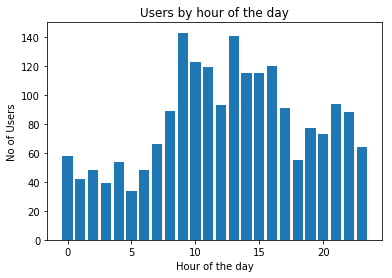

In [29]:
######  Bar chart for number of users by hours #######
### change the color ######
x_axis=HourSession.index
plt.bar(x_axis,HourSession['user_id'])
plt.ylabel('No of Users')
plt.xlabel('Hour of the day')
plt.title('Users by hour of the day')
plt.show()